### Python notebook walking through considerations for choosing the RC lengths, and folding mirror curvatures, for the 40m Ponderomotive Squeezing Experiment

#### Resonance conditions:
 - $f_{1}$ = 11.066209 MHz (set by IMC length)
 - $f_{2}$ = 5  $\times  f_{1}$ 
 - Carrier, $f_{1}$, and $f_{2}$ sidebands have to be simultaneously resonant in the PRC.
 - Carrier and $f_{2}$ sidebands have to be simultaneously resonant (when the arms are resonant), while $f_{1}$ has to be non-resonant in the SRC (for ** detuned ** setup).
 - The coupling of the $f_{2}$ sideband to the SRC is set by the Schnupp asymmetry. We'd like to choose the Schnupp asymmetry to maximize this coupling (ideally we realize critical coupling from the PRC to the SRC).
 - In all of the above, the output coupler for the PRC and the input coupler for the SRC is the compound mirror formed by BS and the two ~37.79m long arm cavities. In fact, $\mathrm{L_{arm}}$ is tweaked to allow the simultaneous resonance of the $f_{1}$ and $f_{2}$ sidebands in the PRC.
 - The $f_{1}$ and $f_{2}$ sidebands have to be anti-resonant (or nearly so) in the arm cavities.

Having established the resonance requirements, all that needs to be done is to choose lengths for the RCs such that the round-trip phase gain by the $\mathrm{TEM_{00}}$ modes of the resonant fields is $2\pi$, while avoiding this condition for the non-resonant fields.

Note: Based on the resonance formulae above: 
 - Shortest candidate PRC lengths are: 6.77m, 20.32m, 33.86m.
 - Shortest candidate SRC lengths are: 1.35m, 4.06m and 9.48m (6.77m is not a great option because then the f1 sideband will also be resonant).


In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as scc
import matplotlib.colors as colors
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
from IPython.display import SVG

#### Interferometer topology
The DRFPMI topology is shown below. 
 - The FPMI reflectivity is calculated with the arms as compound mirrors.
 - IFO reflection is E2/E1
 - Transmission to AS port is E11/E1
 - The adjacency matrix is written down using the graphic below, and solved for the IFO reflection and transmission to AS port [See Adjacency_DRFPMI_GV.nb]

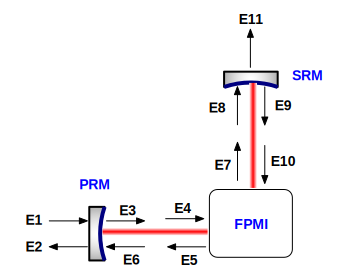

In [2]:
SVG(filename='./IFOschematic.svg')

In [3]:
# Set up some plotting stuff
if 'gvELOG' in plt.style.available:
    plt.style.use('gvELOG')
else:
    mpl.rcParams['lines.linewidth'] = 3
    mpl.rcParams['lines.markersize'] = 10
    mpl.rcParams['axes.titlesize'] = 18
    mpl.rcParams['axes.labelsize'] = 16
    mpl.rcParams['xtick.labelsize'] = 16
    mpl.rcParams['ytick.labelsize'] = 16
    mpl.rcParams['axes.formatter.limits'] = [-2,2]
    mpl.rcParams['axes.grid'] = True
    mpl.rcParams['grid.linestyle'] = '--'
    mpl.rcParams['grid.linewidth'] = 0.7
    mpl.rcParams['grid.alpha'] = 0.4
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams['font.family'] = 'sans-serif'
    mpl.rcParams['font.style'] = 'normal'
    mpl.rcParams['font.weight'] = 'extra bold'
    mpl.rcParams['font.size'] = 16

#### Choosing $\mathrm{L_{arm}}$
 - We require both $f_{1}$ and $f_{2}$ sidebands to be resonant inside the PRC, but nearly anti-resonant in the arm cavities.
 - One way to achieve this is if the phase change on reflection from the FP arm cavity is 5 $\times$ for the $f_{2}$ sideband as compared to the $f_{1}$ sideband.
 - If the * amplitude * reflectivity of the arm is $\mathrm{r_{arm}}$, then $\vec{\mathrm{E}}_{\mathrm{refl}} = \mathrm{r_{arm}}\vec{\mathrm{E}}_{\mathrm{inc}}$.
 - So the phase gained during the reflection process is the argument of the complex number
 $$\mathrm{r_{arm}} = \frac{-r_{\mathrm{ITM}} + r_{\mathrm{ETM}}(t_{\mathrm{ITM}}^2 + r_{\mathrm{ITM}}^2)e^{-i \frac{\omega}{\nu_{\mathrm{FSR}}}}}{1 - r_{\mathrm{ITM}}r_{\mathrm{ETM}}e^{-i \frac{\omega}{\nu_{\mathrm{FSR}}}}}.$$
 - Note that $\frac{\omega}{\nu_{\mathrm{FSR}}} = \frac{2 \omega L}{c} = 2\phi$ so we recover the more conventional expression of $\mathrm{r_{arm}} = \frac{-r_{\mathrm{ITM}} + r_{\mathrm{ETM}}(t_{\mathrm{ITM}}^2 + r_{\mathrm{ITM}}^2)e^{-2i \phi}}{1 - r_{\mathrm{ITM}}r_{\mathrm{ETM}}e^{-2i \phi}}$ where $\phi = \frac{\omega L}{c}$ is the one-way propagation phase.

In [4]:
# 40m IFO parameters (c.f. 40m wiki, core optics page)
# Test masses
T_ITM = 1.384e-2
T_ETM = 13.7e-6
L_ITM = 20e-6 # losses, ppm
L_ETM = 20e-6
L_arm = 37.79 # meters
r_ITM = np.sqrt(1 - T_ITM - L_ITM)
t_ITM = np.sqrt(T_ITM)
r_ETM = np.sqrt(1 - T_ETM - L_ETM)
t_ETM = np.sqrt(T_ETM)

# Power Recycling
T_PRM = 1e-2
L_PRM = 50e-6
t_PRM = np.sqrt(T_PRM)
r_PRM = np.sqrt(1-T_PRM-L_PRM)

# Signal Recycling
T_SRM = 25e-2
L_SRM = 50e-6
t_SRM = np.sqrt(T_SRM)
r_SRM = np.sqrt(1-T_SRM-L_SRM)

# Modulation
f1 = 11.066209e6
f2 = 5*f1

def rArm(ti, te, ri, re, L, f):
    '''
    Computes reflectivity of a resonant FP cavity 
    for a sideband offset at frequency f.
    '''
    FSR = scc.c / (2*L) 
    return (-ri + re*(ti**2 + ri**2)*np.exp(-1j*2*np.pi*f/FSR))/(1 - ri*re*np.exp(-1j*2*np.pi*f/FSR))
lengths = np.linspace(35,45,20000)
rr_f1 = rArm(t_ITM,t_ETM, r_ITM, r_ETM, lengths, f1)
rr_f2 = rArm(t_ITM,t_ETM, r_ITM, r_ETM, lengths, f2)
ang_f1 = np.angle(-rr_f1, deg=True) # minus sign is for scaling the plot...
ang_f2 = np.angle(-rr_f2, deg=True)
argmin = np.argmin(np.abs(ang_f1 - ang_f2/5)),
print('Argmin is {} corresponding to L= {:.4f} m, yielding dPhi = {:.4f} degrees'.format(argmin,
     lengths[argmin], ang_f1[argmin] - ang_f2[argmin]/5))

Argmin is (5589,) corresponding to L= 37.7946 m, yielding dPhi = 0.0001 degrees


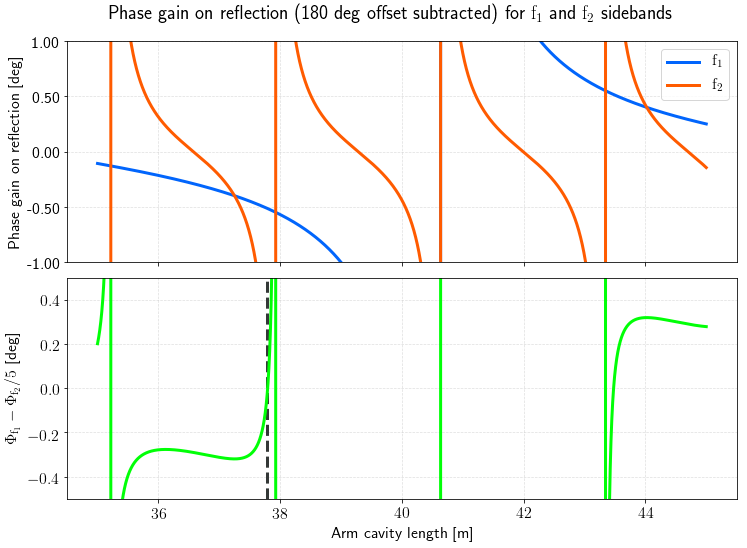

In [5]:
fig, ax = plt.subplots(2,1,sharex=True,figsize=(12,8))
ax[0].plot(lengths, ang_f1, label='$\mathrm{f}_1$', color='xkcd:bright blue')
ax[0].plot(lengths, ang_f2, label='$\mathrm{f}_2$', color='xkcd:bright orange')
ax[1].plot(lengths, ang_f1 - ang_f2/5, label='$\mathrm{f}_1 - \mathrm{f}_2/5$', 
           color='xkcd:bright green')
ax[0].yaxis.set_major_formatter(FormatStrFormatter("%2.2f"))
ax[0].set_ylim([-1,1])
ax[0].legend(loc='best')
ax[1].set_xlabel('Arm cavity length [m]')
ax[0].set_ylabel('Phase gain on reflection [deg]')
ax[1].set_ylim([-0.5,0.5])
ax[1].vlines(37.79, -0.5,0.5,linestyle='--',color='xkcd:charcoal')
ax[1].set_ylabel('$\Phi_{\mathrm{f_1}} - \Phi_{\mathrm{f_2}}/5$ [deg]')
fig.subplots_adjust(wspace=0.07, hspace=0.07, top=0.92)
fig.suptitle('Phase gain on reflection (180 deg offset subtracted) for $\mathrm{f}_{1}$ and $\mathrm{f}_{2}$ sidebands');

#### Reflectivity of the arm cavity for $2f_{1}$ and $2f_{2}$ 
 - The $3f$ locking scheme relies on the $2f_{1}$ and $2f_{2}$ components being reflected from the arms with reflectivity near unity [See K. Arai Thesis, 4.1.1].
 - The $2f$ fields aren't resonant inside the arm cavity either.
 - So in order for the amount of $2f$ light at the symmetric port to be more or less independent of the arm cavity microscopic length, we wish for the reflectivity of the arm cavity for the $2f$ component to be fairly independent of the latter.

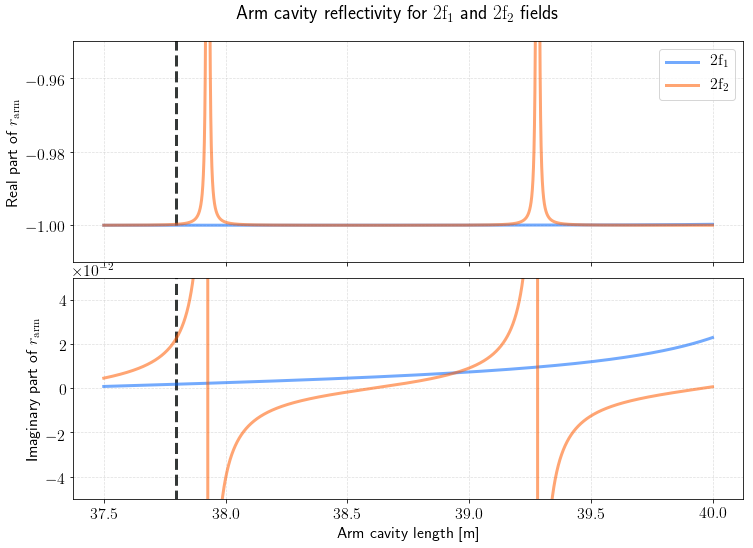

In [6]:
# Some practical lengths given 40m VEA constraints
lengths = np.linspace(37.5,40,20000)
rr_2f1 = rArm(t_ITM,t_ETM, r_ITM, r_ETM, lengths, 2*f1)
rr_2f2 = rArm(t_ITM,t_ETM, r_ITM, r_ETM, lengths, 2*f2)
fig, ax = plt.subplots(2,1,sharex=True, figsize=(12,8))
ax[0].plot(lengths, np.real(rr_2f1), label='$2 \mathrm{f}_1$', color='xkcd:bright blue', alpha=0.55)
ax[1].plot(lengths, np.imag(rr_2f1), label='$2 \mathrm{f}_1$', color='xkcd:bright blue', alpha=0.55)
ax[0].plot(lengths, np.real(rr_2f2), label='$2 \mathrm{f}_2$', color='xkcd:bright orange', alpha=0.55)
ax[1].plot(lengths, np.imag(rr_2f2), label='$2 \mathrm{f}_2$', color='xkcd:bright orange', alpha=0.55)
ax[0].legend(loc='best')
ax[1].set_xlabel('Arm cavity length [m]')
ax[0].set_ylabel('Real part of $r_{\mathrm{arm}}$')
ax[1].set_ylabel('Imaginary part of $r_{\mathrm{arm}}$')
ax[0].vlines(37.795, -1,1,linestyle='--',color='xkcd:charcoal')
ax[1].vlines(37.795, -1,1,linestyle='--',color='xkcd:charcoal')
ax[0].set_ylim([-1.01,-0.95])
ax[1].set_ylim([-0.05,0.05])
fig.subplots_adjust(wspace=0.07, hspace=0.07, top=0.92)
fig.suptitle('Arm cavity reflectivity for $2 \mathrm{f}_{1}$ and $2 \mathrm{f}_{2}$ fields');

#### Dependence of amount of $2f$ power at REFL for various arm lengths, macroscopic detunings
The detailed deriviation is found in the section on Schnupp Asymmetry, but the reflectivity of the full IFO is given by:
$$r_{\mathrm{DRFPMI}}^{\mathrm{sym} \rightarrow \mathrm{sym}} = -r_p + \frac{t_p^2 (|r_A| e^{-i(2\phi_{\mathrm{PRC}}-\theta)}\cos(2 \phi_-) - |r_A|^2 r_S e^{-i(2\phi_{\mathrm{PRC}} + 2\phi_{\mathrm{SRC}} - 2\theta)})}{1 + |r_A|^2r_Pr_S e^{-i(2\phi_{\mathrm{PRC}} + 2\phi_{\mathrm{SRC}}-2\theta)} - |r_A|(r_P e^{-i(2\phi_{\mathrm{PRC}}-\theta)} + r_S e^{-i(2\phi_{\mathrm{SRC}}-\theta)})\cos(2\phi_-)},$$

where the symbols have the following meaning:

$$ L_{\mathrm{PRC}} = L_{\mathrm{PRM} \rightarrow \mathrm{BS}} + \frac{l_{\mathrm{BS} \rightarrow \mathrm{ITMY}} + l_{\mathrm{BS} \rightarrow \mathrm{ITMX}}}{2}$$
$$ L_{\mathrm{SRC}} = L_{\mathrm{SRM} \rightarrow \mathrm{BS}} + \frac{l_{\mathrm{BS} \rightarrow \mathrm{ITMY}} + l_{\mathrm{BS} \rightarrow \mathrm{ITMX}}}{2}$$
$$ l_{\mathrm{schnupp}} = l_{\mathrm{BS} \rightarrow \mathrm{ITMY}} - l_{\mathrm{BS} \rightarrow \mathrm{ITMX}}$$
$$ r_{\mathrm{A}} = |r_{\mathrm{A}}|e^{i \theta}$$
$$ \phi_{\mathrm{PRC}} = \frac{\omega L_{\mathrm{PRC}}}{c} $$
$$ \phi_{\mathrm{SRC}} = \frac{\omega L_{\mathrm{SRC}}}{c} $$
$$ \phi_{-} = \frac{\omega l_{\mathrm{schnupp}}}{2c} $$

In [7]:
def rArm_det(ti, te, ri, re, L, f, phiC):
    '''
    More general form of the earlier defined function,
    such that it allows for the cavity to be detuned.
    '''
    phi = phiC + (2*np.pi*f*L/scc.c)
    return (-ri + re*(ti**2 + ri**2)*np.exp(-2*1j*phi))/(1 - ri*re*np.exp(-2*1j*phi))

def ifo_REFL(rp, rs, tp, ts, ti, te, ri, re, Larm, f, phiC, theta1, theta2):
    # Calculate arm reflectivity
    phi = phiC + (2*np.pi*f*Larm/scc.c)
    rA = (-ri + re*(ti**2 + ri**2)*np.exp(-2*1j*phi))/(1 - ri*re*np.exp(-2*1j*phi))
    mag = np.abs(rA)
    ph = np.angle(rA)
    # Set the PRC length to be resonant for both sidebands, i.e. 6.753m
    Lprc = (theta1/2/np.pi)*scc.c/2/11.066209e6
    phiPRC = 2*np.pi*f*Lprc/scc.c
    # Set the SRC length such that f2 and carrier are resonant
    Lsrc = (1 + theta2/2/np.pi)*scc.c/2/(5*11.066209e6)
    phiSRC =  2*np.pi*f*Lsrc/scc.c
    # Schnupp asy
    phiSchnupp = (2.319e-2)*2*np.pi*f/2/scc.c
    # Calculate the amplitude reflectivity
    num = tp**2 * (mag*np.exp(-1j*(2*phiPRC - ph))*np.cos(phiSchnupp) - mag**2 * rs * np.exp(-1j*(2*phiPRC + 2*phiSRC - 2*ph)))
    den = 1 + mag**2 * rp * rs * np.exp(-1j*(2*phiPRC + 2*phiSRC - 2*ph)) - mag*np.cos(phiSchnupp)*(rp*np.exp(-1j*(2*phiPRC-ph)) + rs*np.exp(-1j*(2*phiSRC-ph)))
    return -rp + num/den

lengths = np.linspace(37.5,40,500)
detunings = np.linspace(-10./532, 10./532, 500)
xx, yy = np.meshgrid(lengths, detunings)
theta1 = np.angle(rArm_det(t_ITM,t_ETM, r_ITM, r_ETM, xx, f1, np.zeros((500,500))))
theta2 = np.angle(rArm_det(t_ITM,t_ETM, r_ITM, r_ETM, xx, f2, np.zeros((500,500))))
rr_f1 = ifo_REFL(r_PRM, r_SRM, t_PRM, t_SRM, t_ITM, t_ETM, r_ITM, r_ETM, lengths, 2*f1, detunings, theta1, theta2)
rr_f2 = ifo_REFL(r_PRM, r_SRM, t_PRM, t_SRM, t_ITM, t_ETM, r_ITM, r_ETM, lengths, 2*f2, detunings, theta1, theta2)
#rr_f1 = rArm_det(t_ITM,t_ETM, r_ITM, r_ETM, xx, f1, yy)
#rr_f2 = rArm_det(t_ITM,t_ETM, r_ITM, r_ETM, xx, f2, yy)                              

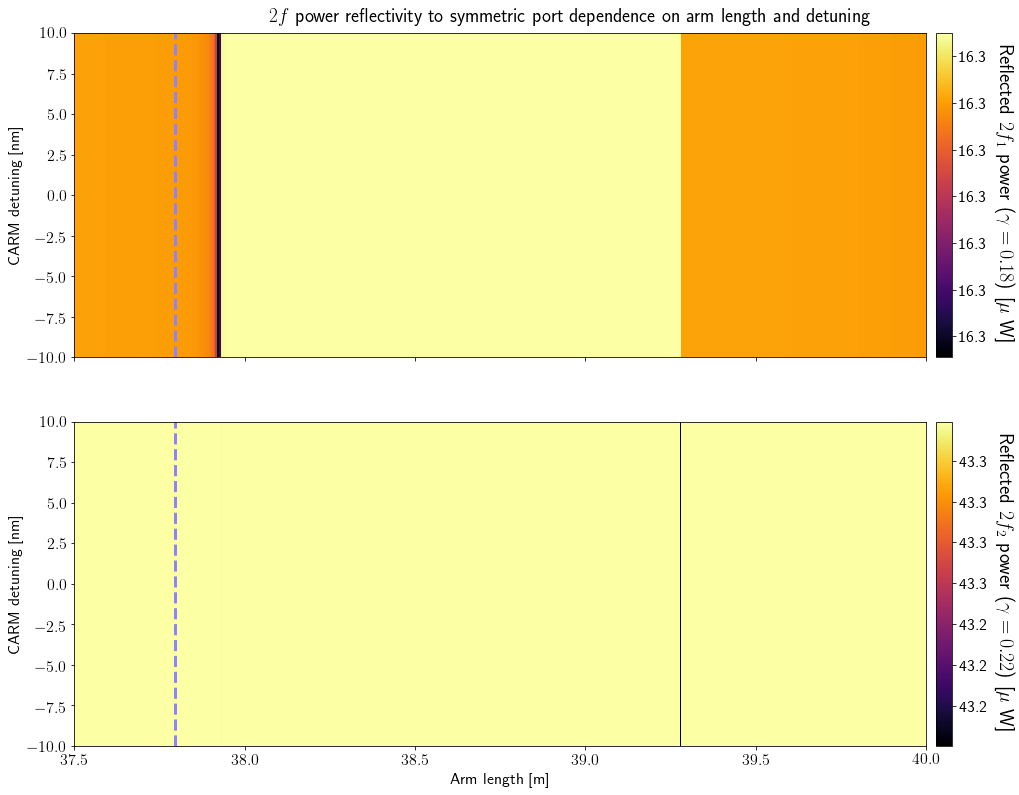

In [8]:
# This cell takes ~30 seconds to execute for a 500x500 grid
from scipy.special import jv
Pref_2f1 = (jv(2,0.18)**2) * np.abs(rr_f1)**2
Pref_2f2 = (jv(2,0.23)**2) * np.abs(rr_f2)**2

fig, ax = plt.subplots(2,1,figsize=(16,12), sharex=True)
heatmap1 = ax[0].pcolor(xx,532*yy,1e6*Pref_2f1, cmap='inferno')
heatmap2 = ax[1].pcolor(xx,532*yy,1e6*Pref_2f2, cmap='inferno')
c1=fig.colorbar(heatmap1, 
                pad=0.01, ax=ax[0], format='%2.1f')
c2=fig.colorbar(heatmap2, 
                pad=0.01, ax=ax[1], format='%2.1f')
c1.set_label('Reflected $2f_1$ power ($\gamma = 0.18$) [$\mu$ W]',rotation=270, labelpad=25, fontsize=20)
c2.set_label('Reflected $2f_2$ power ($\gamma = 0.22$) [$\mu$ W]',rotation=270, labelpad=25, fontsize=20)
ax[0].vlines(37.795, -10,10,linestyle='--',color='xkcd:periwinkle')
ax[1].vlines(37.795, -10,10,linestyle='--',color='xkcd:periwinkle')
ax[1].set_xlabel('Arm length [m]')
ax[0].set_ylabel('CARM detuning [nm]')
ax[1].set_ylabel('CARM detuning [nm]')
fig.suptitle('$2f$ power reflectivity to symmetric port dependence on arm length and detuning')
fig.subplots_adjust(left=0.07, right=0.95, top=0.95)

#### Simultaneous resonance of $f_{1}$ and $f_{2}$ sidebands in the PRC
 - Having chosen the macroscopic arm length of $\mathrm{L_{arm}} = 37.795 \mathrm{m}$, we can now tune the SRC and PRC lengths to satisfy various resonance conditions.
 - Using this arm length, we can calculate the (complex) reflectivity of the arm ($r_{\mathrm{arm}} = |r_{\mathrm{arm}}|e^{i\theta}$).
 - Then we use the expression for circulating field in the FP cavity:
 $$\vec{\mathrm{E}}_{\mathrm{circ}} = \vec{\mathrm{E}}_{\mathrm{in}}\frac{t_{\mathrm{PRM}}}{1-r_{\mathrm{PRM}}r_{\mathrm{arm}}e^{-i \frac{\omega}{\nu_{\mathrm{FSR}}}}},$$ and choose the macroscopic cavity length that maximizes the circulating power for the $f_{1}$ and $f_{2}$ components for the desired operating point of the carrier.
 - Note that $\omega = \omega_0$ for the carrier, and $\omega = \omega_0 \pm \Omega_i$ for the sideband fields.
 - The correction due to the complex arm reflectivity is that we choose $\mathrm{L_{PRC}} =  (N+\frac{\theta_1}{2\pi})\frac{c}{2f_1}$, $N \in \mathbb{Z} ^+$ instead of $\mathrm{L_{PRC}} =  (N+\frac{1}{2})\frac{c}{2f_1}$, $N \in \mathbb{Z} ^+$, where $\theta_1$ is the argument of the complex arm reflectivity for the $f_1$ sideband. 
 - For the 40m PonderSqueeze experiment, we propose k = 0 and $\theta_1 \approx 180.5^\circ$ and $\theta_2 = 182.5^\circ$, such that $L_{\mathrm{PRC}} = 6.753 \mathrm{m}$.

In [9]:
larm = 37.795
r_f1 = rArm(t_ITM,t_ETM, r_ITM, r_ETM, larm, f1)
r_f2 = rArm(t_ITM,t_ETM, r_ITM, r_ETM, larm, f2)
r_carr = rArm(t_ITM,t_ETM, r_ITM, r_ETM, larm, 0.)

def gPRC(tp, rp, rarm, L, f):
    '''
    Computes circulating power in the PRC, with compound
    mirror formed by the arm cavity, for a sideband offset at frequency f.
    '''
    FSR = scc.c / (2*L) 
    return (tp/(1 - rp*rarm*np.exp(-1j*2*np.pi*f/FSR)))
lengths = np.linspace(6.7, 6.8, 1000)
gPRC_f1 = gPRC(t_PRM, r_PRM, r_f1, lengths, f1)
gPRC_f2 = gPRC(t_PRM, r_PRM, r_f2, lengths, f2)
gPRC_carr = gPRC(t_PRM, r_PRM, r_carr, lengths, 0.)
f1Max = lengths[np.argmax(np.abs(gPRC_f1)**2)]
f2Max = lengths[np.argmax(np.abs(gPRC_f2)**2)]
print('Maximum buildup for f1 sideband is for Lprc = {0:.4f}'.format(f1Max))
print('Maximum buildup for f2 sideband is for Lprc = {0:.4f}'.format(f2Max))

Maximum buildup for f1 sideband is for Lprc = 6.7533
Maximum buildup for f2 sideband is for Lprc = 6.7533


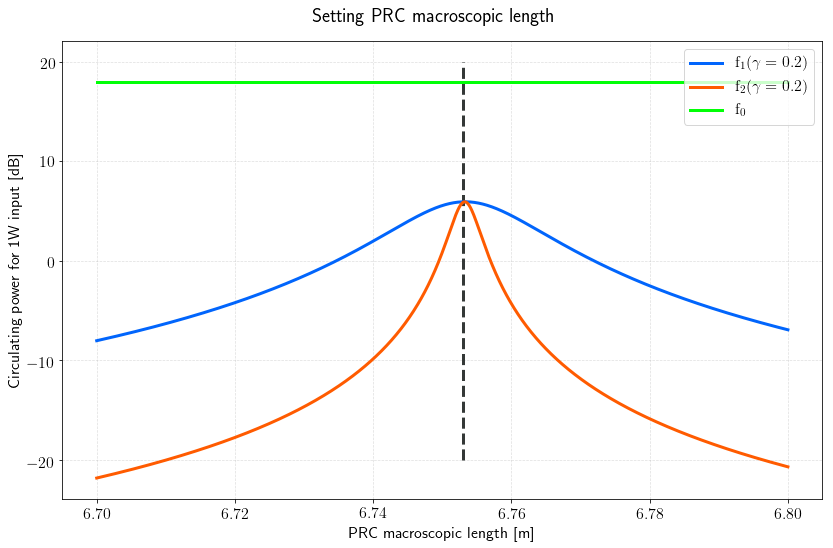

In [10]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(lengths, 10*np.log10(0.01*np.abs(gPRC_f1)**2), 
        label='$\mathrm{f_1} ( \gamma = 0.2)$',color='xkcd:bright blue')
ax.plot(lengths, 10*np.log10(0.01*np.abs(gPRC_f2)**2), 
        label='$\mathrm{f_2} ( \gamma = 0.2)$',color='xkcd:bright orange')
ax.plot(lengths, 10*np.log10(np.abs(gPRC_carr)**2), 
        label='$\mathrm{f_0}$',color='xkcd:bright green')
ax.vlines(6.753,-20,20,linestyle='--',color='xkcd:charcoal')
ax.set_ylabel('Circulating power for 1W input [dB]')
ax.set_xlabel('PRC macroscopic length [m]')
ax.legend(loc='upper right')
fig.suptitle('Setting PRC macroscopic length')
fig.subplots_adjust(left=0.07, right=0.95, top=0.92)

#### Setting the SRC macroscopic length
 - For PonderSqueeze, we need the carrier to be resonant in the SRC (when the arms are resonant for the carrier).
 - Actually, there is a small detuning for the carrier, of roughly $0.01^\circ$ 
 - $f_{2}$ sideband has to be resonant.
 - $f_{1}$ sideband has to be non-resonant.

Maximum buildup for f2 sideband happens for an SRC length of 4.0443 m


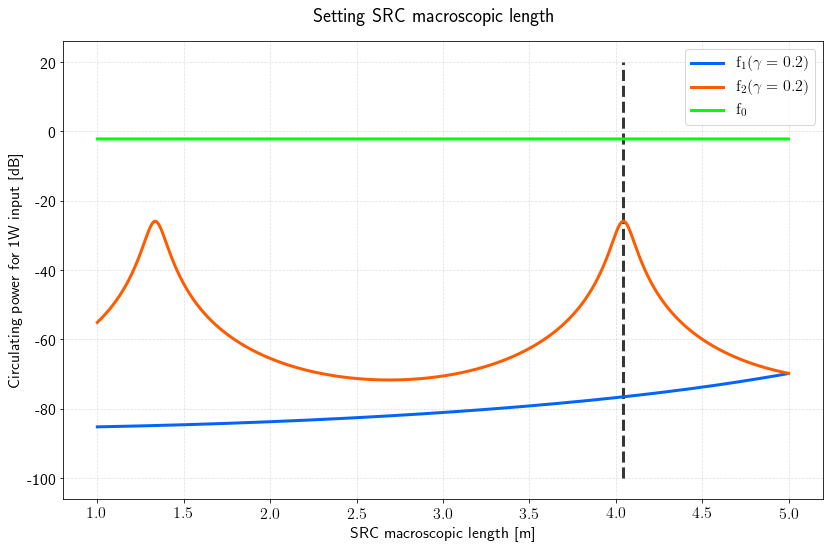

In [11]:
def gSRC(tarm, rarm, rs, L, f):
    '''
    Computes circulating power in the SRC, with compound
    mirror formed by the arm cavity, for a sideband offset at frequency f.
    '''
    FSR = scc.c / (2*L) 
    return (tarm/(1 - rarm*rs*np.exp(-1j*(2*np.pi*f/FSR))))
lengths = np.linspace(1, 5, 10000)
gSRC_f1 = gSRC(np.sqrt(1 - r_f1**2 - L_ITM - L_ETM), r_f1, r_SRM, lengths, f1)
gSRC_f2 = gSRC(np.sqrt(1 - r_f2**2 - L_ITM - L_ETM), r_f2, r_SRM, lengths, f2)
gSRC_carr = gSRC(np.sqrt(1 - r_carr**2 - L_ITM - L_ETM), r_carr, r_SRM, lengths, 0)

fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(lengths, 20*np.log10(0.01*np.abs(gSRC_f1)**2), 
        label='$\mathrm{f_1} ( \gamma = 0.2)$',color='xkcd:bright blue')
ax.plot(lengths, 20*np.log10(0.01*np.abs(gSRC_f2)**2), 
        label='$\mathrm{f_2} ( \gamma = 0.2)$',color='xkcd:bright orange')
ax.plot(lengths, 20*np.log10(np.abs(gSRC_carr)**2), 
        label='$\mathrm{f_0}$',color='xkcd:bright green')
ax.set_ylabel('Circulating power for 1W input [dB]')
ax.set_xlabel('SRC macroscopic length [m]')
ax.yaxis.set_major_formatter(FormatStrFormatter('%2d'))
ax.vlines(lengths[np.argmax(20*np.log10(np.abs(gSRC_f2)**2))],-100,20,linestyles='--',color='xkcd:charcoal')
ax.legend(loc='upper right')
fig.suptitle('Setting SRC macroscopic length')
fig.subplots_adjust(left=0.07, right=0.95, top=0.92)
print('Maximum buildup for f2 sideband happens for an SRC length of {0:.4f} m'.format(lengths[np.argmax(20*np.log10(np.abs(gSRC_f2)**2))]))

#### Schnupp asymmetry
Having set the resonance conditions of the PRC and SRC, we wish for the Michelson transmission for $f_2$ to be large, but for $f_1$ to be small. Basically, we would like to critically couple the $f_2$ sideband to the dark port. Because of the SRM, we cannot simply consider the transmissivity of the Michelson. Furthermore, the arm reflectivity is in general a complex number, which we can write as $r_{\mathrm{arm}} = |r_{\mathrm{arm}}|e^{i\theta}$. The phase of this complex number can then be grouped with the PRC/SRC phase for the desired operating point. The expression for the transmission, for the more general case where we have arbitrary SRC tuning given by $\phi_{\mathrm{SRC}}$, is ($l_{\mathrm{sch}} = l_\mathrm{Y}-l_\mathrm{X}$):


$$t_{\mathrm{DRFPMI}}^{\mathrm{sym} \rightarrow \mathrm{as}} = \frac{e^{-i(\phi_{\mathrm{PRC}} + \phi_{\mathrm{SRC}} - \theta)} |r_A| t_P t_S \sin(2\phi_-)}{1 + |r_A|^2r_Pr_S e^{-i(2\phi_{\mathrm{SRC}}-\theta)} - |r_A|(r_P + r_S e^{-i(2\phi_{\mathrm{SRC}}-\theta)})\cos(2\phi_-)}.$$

*Note: Why does $\theta$ and not $2\theta$ appear in the exponent for the term in the denominator with the coefficient $|r_A|^2$ when we are assuming $r_A = |r_A|e^{i\theta}$? Because as derived earlier, the actual argument of the exponential is $-i(2\phi_{\mathrm{PRC}} + 2\phi_{\mathrm{SRC}} - 2\theta)$, and we have used the fact that $-i(2\phi_{\mathrm{PRC}} - \theta) = 0$ for the sideband being resonant in the PRC.

For the common cases:

RSE: $\phi_{\mathrm{SRC}}(\Omega) = \pi/2 + \Omega l_{\mathrm{SRC}}/c$

SR: $\phi_{\mathrm{SRC}}(\Omega) = 0 + \Omega l_{\mathrm{SRC}}/c$

Optimal Schnupp asymmetry is 2.319 cm for which f2 transmission to dark port is 99.712 %.
Ratio of f1/f2 power buildup in the SRC is 2.36E-03


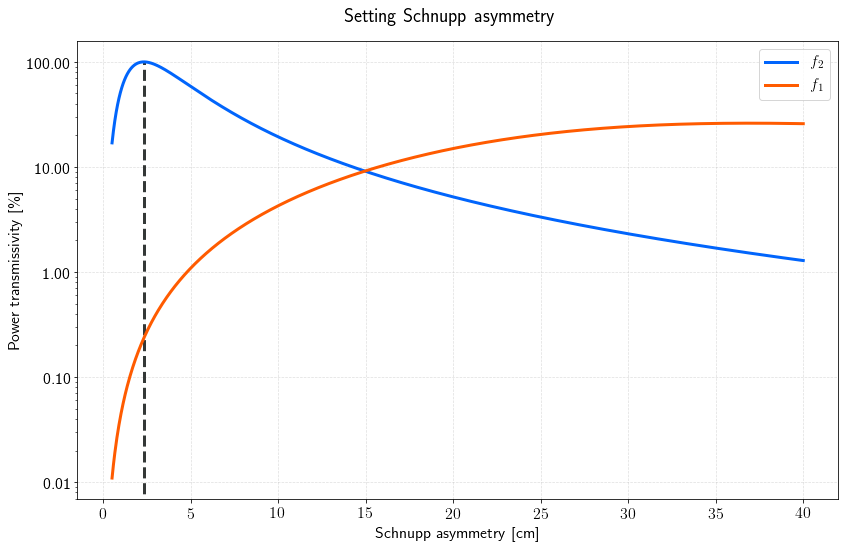

In [16]:
def tDRMI(rA,tp,ts,rp,rs,ls,wm, phiC, lSRC):
    mag = np.abs(rA)
    ph = np.angle(rA)
    phiSRC = phiC + wm*lSRC/scc.c
    return (np.exp(-1j*(phiSRC-ph))*tp*ts*np.abs(mag*np.sin(wm*ls/scc.c))/(1 + 
                                        mag**2*rp*rs*np.exp(-1j*(2*phiSRC - ph)) - 
                                        mag*(rp+rs*np.exp(-1j*(2*phiSRC - ph)))*np.cos(wm*ls/scc.c)))
lls = 1e-2 * np.linspace(0.5,40,1000)
tt_f2 = tDRMI(r_f2,np.sqrt(1e-2),np.sqrt(0.25),np.sqrt(1.-1e-2),np.sqrt(1.-0.25),lls,2*np.pi*f2,0,4.0443)
tt_f1 = tDRMI(r_f1,np.sqrt(1e-2),np.sqrt(0.25),np.sqrt(1.-1e-2),np.sqrt(1.-0.25),lls,2*np.pi*f1,0,4.0443)

fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.semilogy(100*(lls), 100*np.abs(tt_f2)**2, color='xkcd:bright blue', label='$f_2$')
ax.semilogy(100*(lls), 100*np.abs(tt_f1)**2, color='xkcd:bright orange', label='$f_1$')
ax.legend(loc='best')
ax.set_ylabel('Power transmissivity [\%]')
ax.set_xlabel('Schnupp asymmetry [cm]')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.vlines(100*lls[np.argmax(np.abs(tt_f2)**2)],0,100,linestyles='--',color='xkcd:charcoal')
fig.suptitle('Setting Schnupp asymmetry')
fig.subplots_adjust(left=0.07, right=0.95, top=0.92)
maxT_f2 = np.max(100*np.abs(tt_f2)**2) 
print('Optimal Schnupp asymmetry is {0:.3f} cm for which f2 transmission to dark port is {1:.3f} %.'.format(100*lls[np.argmax(np.abs(tt_f2)**2)], 
                                                                                                  maxT_f2))
print('Ratio of f1/f2 power buildup in the SRC is {0:.2E}'.format(np.abs(tt_f1[np.argmax(np.abs(tt_f2)**2)]/tt_f2[np.argmax(np.abs(tt_f2)**2)])**2))

In [13]:
lSRCs = np.linspace(2.5,4.2,1000)
xx, yy = np.meshgrid(lls,lSRCs)
pSRC = tDRMI(r_f2,np.sqrt(1e-2),np.sqrt(0.1),np.sqrt(1.-1e-2),np.sqrt(1.-0.1),xx,2*np.pi*f2,0,yy)

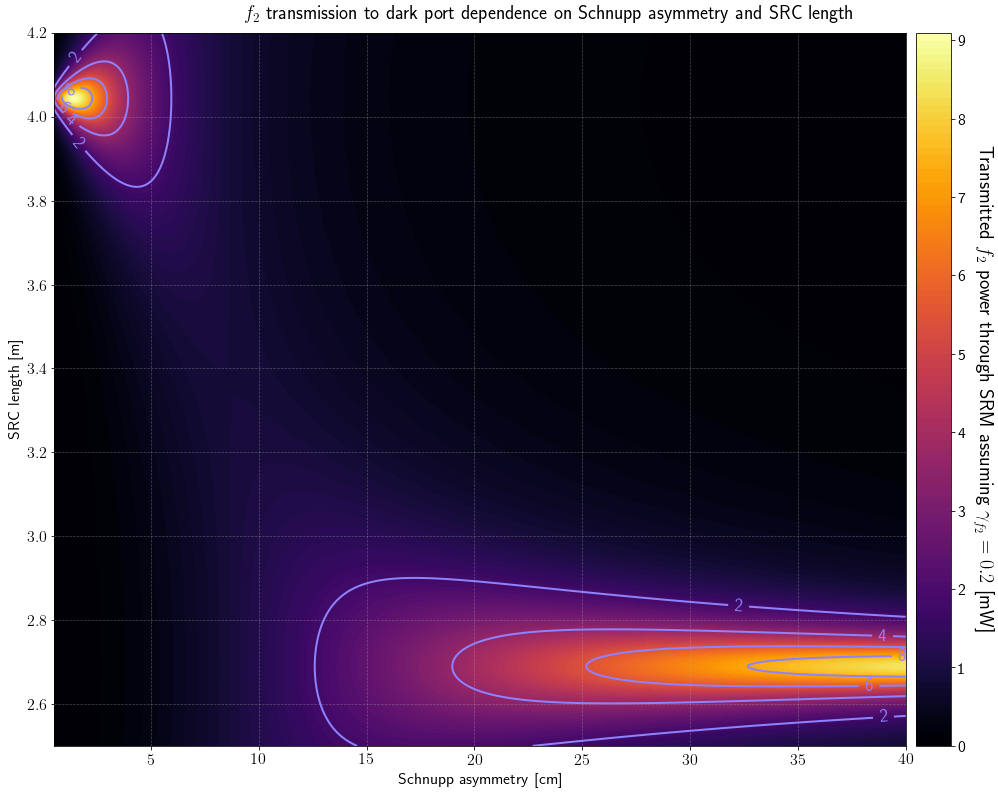

In [14]:
fig, ax = plt.subplots(1,1,figsize=(16,12))
heatmap = ax.contourf(100*xx,yy,1e3*0.01*np.abs(pSRC)**2,100, cmap='inferno',
                     vmin=0.9*np.min(1e3*0.01*np.abs(pSRC)**2), 
                      vmax=np.max(1e3*0.01*np.abs(pSRC)**2))
levels = [2, 4, 6, 8]
C1 = ax.contour(100*xx, yy, 1e3*0.01*np.abs(pSRC)**2,levels,colors='xkcd:periwinkle', linewidths=2)
c1=fig.colorbar(heatmap, format='%3d', 
                pad=0.01)
c1.set_label('Transmitted $f_2$ power through SRM assuming $\gamma_{f_2}=0.2$ [mW]',rotation=270, labelpad=25, fontsize=20)
ax.clabel(C1, colors = 'xkcd:periwinkle', fmt = '%1d', fontsize = 18)
ax.set_xlabel('Schnupp asymmetry [cm]')
ax.set_ylabel('SRC length [m]')
fig.suptitle('$f_2$ transmission to dark port dependence on Schnupp asymmetry and SRC length')
fig.subplots_adjust(left=0.07, right=0.95, top=0.95)

#### Sensing response
Next, we'd like to get some idea of what kind of sensing response we can expect for a given RC configuration. Assume we have Photodiodes at REFL11, REFL55 and AS55. Using the Adjacency Matrix, we can extract the coupling from any port to any other port. For small modulation depths, the sideband power is well approximated by $P_{\mathrm{carrier}} \approx J_0(\gamma)P_0$, $P_{\mathrm{SB}} \approx J_{1}(\gamma)P_0$. The RF photocurrent at any given port is given by:

$$I_{\mathrm{RF}} \propto \left (\sum_{i=0}^{2} c_i(\gamma) E_i \right )^2 $$

where the subscript indexes the carrier, $f_1$ and $f_2$ sidebands and $c_i(\gamma)$ encodes the dependence on modulation depth $\gamma$. For $3f$ demodulation, we need to explicitly include the higher order terms in the Jacobi-Anger expansion instead of using the small modulation-depth approximation.

The actual error signal is demodulated down to DC (i.e. we wish to isolate the component of $I_{\mathrm{RF}}$ that oscillates at $\omega_0 \pm \Omega$). Following the approach of Mizuno and Yamaguchi (1999), in terms of the m-th element of the Adjacency Matrix $\mathcal{A}_m (\Omega, \phi)$, the sensing response is given by:

$$\Re [H_m e^{-i\theta}],$$
$$\Re \left [ (\mathcal{A}^*_m (\omega_0 -\Omega, \phi) \mathcal{A}_m (\omega_0, \phi) + \mathcal{A}^*_m (\omega_0, \phi) \mathcal{A}_m (\omega_0 + \Omega, \phi))e^{-i \theta} \right ],$$

where $\phi$ denotes the tuning of a particular degree of freedom (while the others are assumed to be at their nominal operating points) and $\theta$ denotes the demodulation phase (so basically we need to demodulate at $\theta = 0, \pi/2$ for I and Q respectively).

#### HoMs and mode-matching between the RC and arm cavities

To summarize the optimal cavity lengths:
 - $L_{\mathrm{arm}} = 37.795 m$
 - $L_{\mathrm{PRC}} = 6.753 m$
 - $L_{\mathrm{SRC}} = 4.044 m$
 - $l_{\mathrm{schnupp}} = 2.319 cm$

For the recycling cavities, criteria motivating the the choice of RoC of the mirrors are:
 - Stability of the RCs (i.e. sufficient TMS).
 - Good mode-matching between the arm mode and the RC mode.
 - Avoid HoMs resonating in the arms.
 - Curvature of all optics forming the (folded) cavities should be ~150 m, which is probably a number that manufacturers can meet without problems (since this corresponds to a sagitta of 4.83 $\mu$m for a 3-inch optic, 2.15 $\mu$m for a 2-inch optic). Of course the more important spec is what the tolerance is on the RoC (and equivalently the sag).

The calculation is identical to that done for determining the RC lengths and Schnupp Asymmetry, the main difference being the addition of the Gouy phase for the higher order HG gaussian modes, and that the length tuning is microscopic rather than macroscopic.

In order to calculate the round trip Gouy phase, we follow the derivation of T1300189. If the **round trip** ABCD matrix for a cavity (whose individual elements have an ABCD matrix given by $\mathcal{M}_i$) is given by
$$ M_{\mathrm{RT}} = \prod_{i}\mathcal{M}_{i} = \begin{bmatrix} A & B \\ C & D \end{bmatrix}, $$
the round trip Gouy Phase is given by 
$$ \zeta = 2 \cos^{-1} \left ( \mathrm{sgn} B \sqrt{\frac{A+D+2}{4}} \right ). $$